14×5 Matrix{Float64}:
  0.099546    0.0998364     0.224909    0.848895    24.8805
  0.066776    0.0676274     0.290206    1.36448     31.9048
  0.130993    0.13379       0.359481    1.41008     31.4529
  0.154093    0.164398      0.51966     7.40212    311.833
  0.0994785   0.110111      0.616826    7.51247    311.232
  0.380312    0.37816       0.667142    2.53544     40.9809
  0.0867738   0.0941724     0.815399    7.50507    309.837
  0.550528    0.554087      1.43779     5.43978     85.5066
  0.0638068   0.0778958     1.45574    13.2846     361.919
  0.0331965   0.088477      9.62055    40.6343     783.72
  0.0558032   0.164952     11.5805     45.6084     752.128
  0.151795    0.571988     36.0754    145.125     2471.33
  0.273676    0.836632    106.728     371.237     4309.95
 17.6602     71.2882     5269.28       Inf          Inf

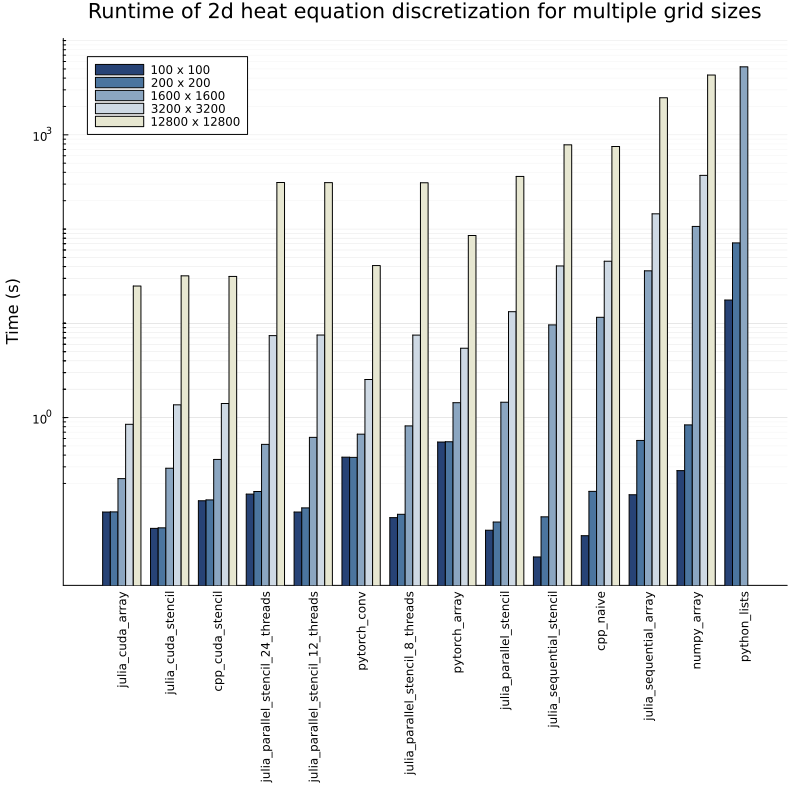

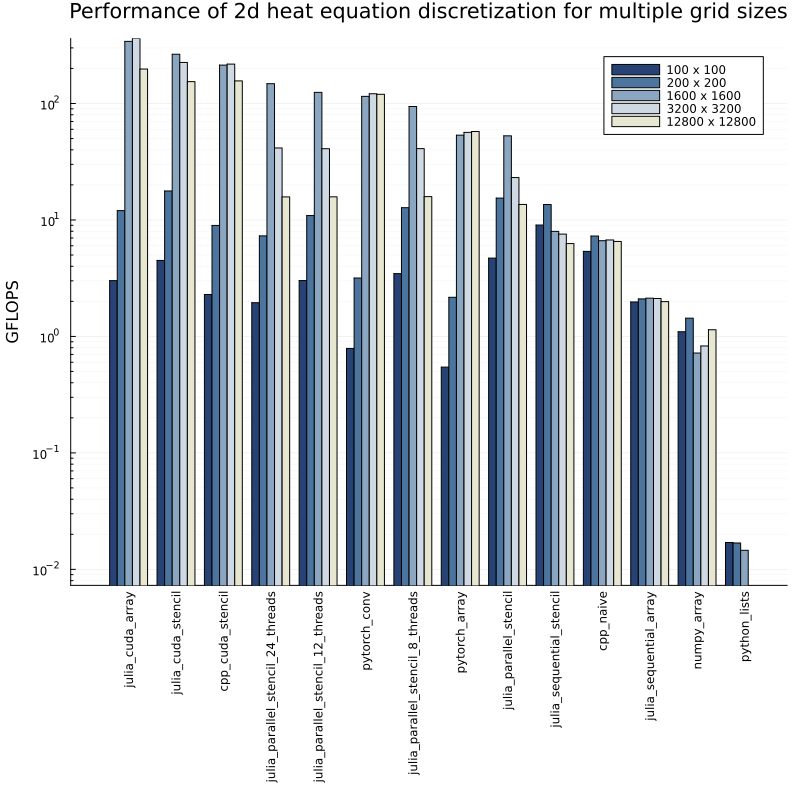

In [1]:
using Plots
using StatsPlots
using YAML
using Statistics
using Measurements
benchmarks = YAML.load_file("benchmark_results.yaml")
benchmark_names = sort(collect(keys(benchmarks)), by= x->parse(Int, first(split(x, "."))))
benchmark_names = benchmark_names[[1,2,5,6,8]]
benchmark_numbers = [parse(Int, first(split(b, "."))) for b in benchmark_names]
num_setups = length(benchmark_names)
implementation_names = collect(keys(benchmarks[first(benchmark_names)]))
max_time_by_implementation = [median([haskey(benchmarks[b],i) ? benchmarks[b][i]["time"]["median"] : Inf for b in benchmark_names]) for i in implementation_names]
sort_permutation = sortperm(max_time_by_implementation)
implementation_names = collect(implementation_names[sort_permutation])
num_implementations = length(implementation_names)
medians = Matrix{Measurement{Float64}}(undef,(num_implementations,num_setups))#zeros(num_implementations, num_setups)
flops= Matrix{Measurement{Float64}}(undef,(num_implementations,num_setups))

num_iterations = 5000
num_computations_per_grid_point = 6
num_gridpoints= benchmark_numbers.^2
num_computations= num_computations_per_grid_point*num_gridpoints * num_iterations

for (i, benchmark_name) in enumerate(benchmark_names)
    benchmark = benchmarks[benchmark_name]
    for (j, implementation_name) in enumerate(implementation_names)
        if !haskey(benchmark, implementation_name)
            medians[j, i] = Inf
            flops[j, i] = -Inf
            continue
        end
        implementation = benchmark[implementation_name]
        time = implementation["time"]["median"] ± implementation["time"]["std"]
        medians[j, i] = time
        flops[j, i] = num_computations[i]/time / 1e9
    end
end
min_time = minimum(filter(isfinite,Measurements.value.(medians)))
max_time= maximum(filter(isfinite,Measurements.value.(medians)))
benchmark_labels =["$(first(split(b, "."))) x $(first(split(b, ".")))" for b in benchmark_names]
display(Measurements.value.(medians))
p=groupedbar(Measurements.value.(medians), yscale=:log10,
    xticks=(eachindex(implementation_names), implementation_names), xrotation=90, ylims=(min_time*0.5, max_time*2), 
    size=(800, 800), yminorgrid=true, xgrid=false, ylabel="Time (s)", title="Runtime of 2d heat equation discretization for multiple grid sizes",
    label=hcat(benchmark_labels...), palette=:broc10
    )
savefig(p, "figures/benchmark_results.png")
display(p)

min_flops = minimum(filter(isfinite,Measurements.value.(flops)))
max_flops= maximum(filter(isfinite,Measurements.value.(flops)))

p=groupedbar(Measurements.value.(flops), yscale=:log10,
    xticks=(eachindex(implementation_names), implementation_names), xrotation=90, ylims=(min_flops*0.5, max_flops), 
    size=(800, 800), yminorgrid=true, xgrid=false, ylabel="GFLOPS", title="Performance of 2d heat equation discretization for multiple grid sizes",
    label=hcat(benchmark_labels...), legend=:topright, palette=:broc10
    )
savefig(p, "figures/benchmark_results_flops.png")
display(p)

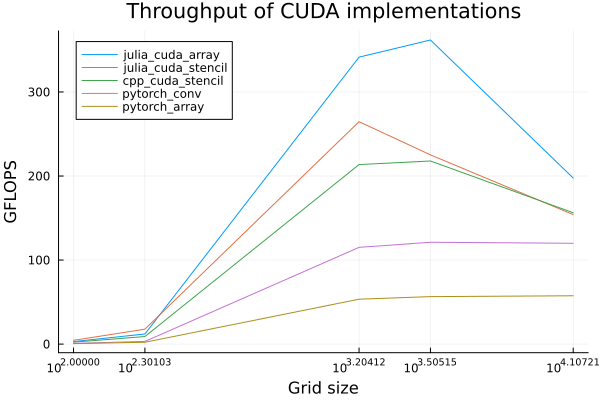

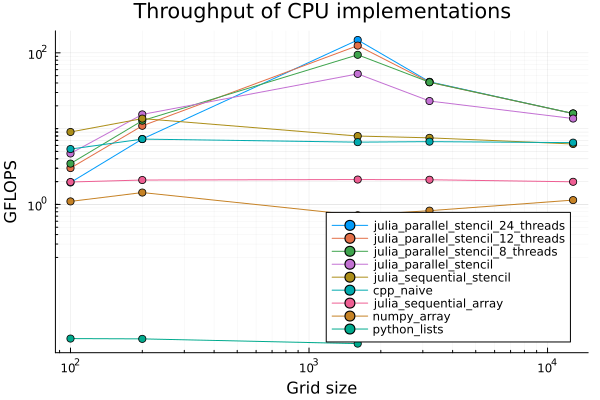

┌ Warning: Skipped marker arg ..
└ @ Plots /Users/ole/.julia/packages/Plots/ju9dp/src/args.jl:1149


"/Users/ole/Documents/Studium/master/hpc_seminar/hpc-lab/figures/benchmark_results_cpu_flops.png"

In [2]:
using Plots

cuda_mask=contains.(implementation_names, "cuda") .| contains.(implementation_names, "torch")
cpu_mask=@. !cuda_mask

plot(benchmark_numbers, Measurements.value.(flops[cuda_mask,:])', label=hcat(implementation_names[cuda_mask]...), xlabel="Grid size", ylabel="GFLOPS", title="Throughput of CUDA implementations", legend=:topleft,xticks=benchmark_numbers,xscale=:log10) |> display
savefig("figures/benchmark_results_cuda_flops.png")

plot(benchmark_numbers , Measurements.value.(flops[cpu_mask,:])', label=hcat(implementation_names[cpu_mask]...), xlabel="Grid size", ylabel="GFLOPS", title="Throughput of CPU implementations", legend=:bottomright, xscale=:log10, minorgrid=true, marker=".", yscale=:log10) |> display
savefig("figures/benchmark_results_cpu_flops.png")

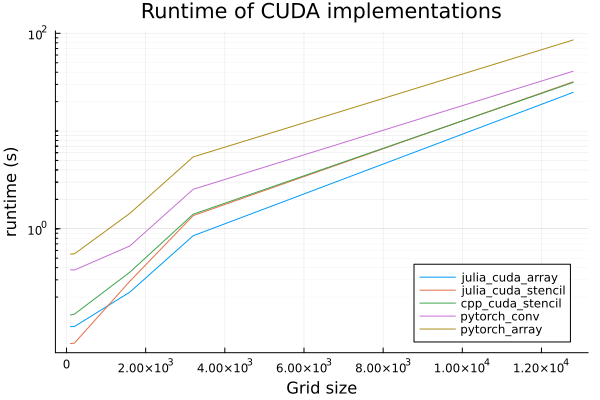

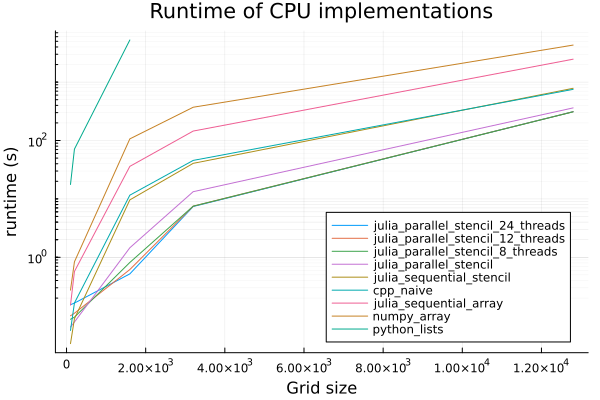

"/Users/ole/Documents/Studium/master/hpc_seminar/hpc-lab/figures/benchmark_results_cpu_flops.png"

In [3]:
using Plots

cuda_mask=contains.(implementation_names, "cuda") .| contains.(implementation_names, "torch")
cpu_mask=@. !cuda_mask

plot(benchmark_numbers, Measurements.value.(medians[cuda_mask,:])', label=hcat(implementation_names[cuda_mask]...), xlabel="Grid size", ylabel="runtime (s)", title="Runtime of CUDA implementations", legend=:bottomright, yscale=:log10, yminorgrid=true) |> display
savefig("figures/benchmark_results_cuda_flops.png")

plot(benchmark_numbers , Measurements.value.(medians[cpu_mask,:])', label=hcat(implementation_names[cpu_mask]...), xlabel="Grid size", ylabel="runtime (s)", title="Runtime of CPU implementations", legend=:bottomright,yscale=:log10, yminorgrid=true) |> display
savefig("figures/benchmark_results_cpu_flops.png")